In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix, coo_matrix, triu
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

large_file_path = "./../../../large_data_files"
k_neighbors = 50

In [3]:
patient_icd_sparse_path = "./../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p"
pdata = pickle.load(open(patient_icd_sparse_path, "rb"))
pdata.shape

(46520, 6984)

In [6]:
"""
Load the Annoy tree for approximate nearest neighbors.
"""
ANNOY_PATH = "../../../large_data_files"
annoy_path = os.path.join(ANNOY_PATH, "200214_patient_similarity_clusters_default.ann")

cos_knn_tree = AnnoyIndex(pdata.shape[1], "angular")
cos_knn_tree.load(annoy_path)

"""
Build adjacency matrix A.

In first pass, I fill in each row, so A is not yet symetric. I make it symetricin the next code block. 
"""
gamma = 2
print("Building dense data matrix with k={} nn...".format(k_neighbors))
A = np.zeros((pdata.shape[0], pdata.shape[0]))
for i in tqdm(range(pdata.shape[0])):
    #Not including self-loops or self-nearest neighbors via "+1" and [1:]
    nn_idxs = cos_knn_tree.get_nns_by_item(i, k_neighbors + 1)[1:]
    cos_distances = [cos_knn_tree.get_distance(i, nn) for nn in nn_idxs]
    rbf_distances = [np.exp(-gamma*cos_dist**2) for cos_dist in cos_distances]
    A[i, nn_idxs] = rbf_distances

  0%|          | 4/46520 [00:00<19:58, 38.81it/s]

Building dense data matrix with k=50 nn...


100%|██████████| 46520/46520 [09:58<00:00, 77.79it/s]


In [7]:
"""
Make A symetric by only including mutual nearest neighbors
"""

#{Key:Value} = {Patient Index: List of nearest Neighbor indices}
knn_adj = {}

#Populate dictionary
for i in tqdm(range(A.shape[0])):
    nn_idx = set(np.nonzero(A[i])[0])
    knn_adj[i] = nn_idx

#Check for mutual nearest neighbors. 
##Set location to 0 if not mutual nearest neighbors
for i in tqdm(range(A.shape[0])):
    nns = knn_adj[i]
    for nn in nns:
        if i not in knn_adj[nn]:
            A[i, nn] = 0
            knn_adj[]

pickle.dump(csr_matrix(A), open("./data/A_FULL_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

100%|██████████| 46520/46520 [00:01<00:00, 25776.28it/s]


# A loading

In [21]:
A = pickle.load(open("./data/A_FULL_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
A.shape

(46520, 46520)

In [22]:
"""Sanity Check: Matrix is indeed symetric"""
print(np.array_equal(A.data, A.T.data))
print(np.array_equal(A.indices, A.T.indices))

True
True


In [23]:
k_neighbors = 50
# A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

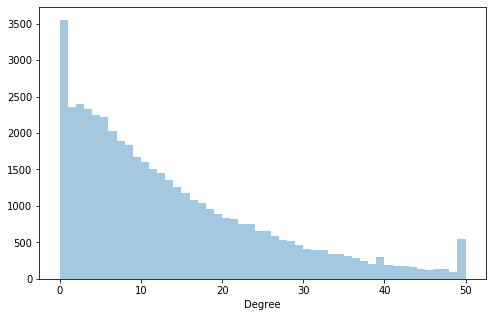

In [24]:
"""Plot the distribution of nearest neighbors"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_RAW.png".format(k_neighbors))

### A: remove empty patients and outliers

In [25]:
"""
Remove patients without any nearest neighbors
Remove patients with full (50) nearest neighbors. The communities can be thought of as "outliers"
"""

#Works because A is symetric
rows_with_vals = np.unique(A.indices)

A_nonempty = A[rows_with_vals][:, rows_with_vals]
print(type(A_nonempty))
print("Shape after removing empty patients:", A_nonempty.shape)

<class 'scipy.sparse.csr.csr_matrix'>
Shape after removing empty patients: (42970, 42970)


[Text(0.5, 0, 'Degree')]

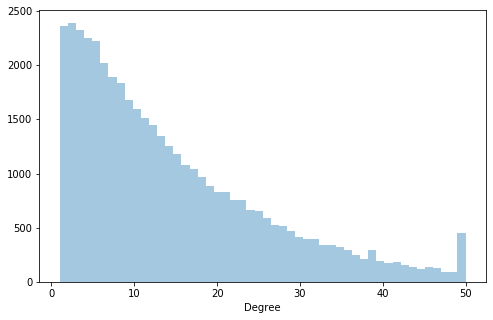

In [26]:
"""Plot the distribution with empty patients removed"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_nonempty.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")

In [27]:
"""
Remove patients with k_neighbors nearest neighbors. 
"""

patient_degrees = np.count_nonzero(A_nonempty.toarray(), axis=0)

#Sanity check to ensure all empty patients have been removed
print(patient_degrees.shape)

threshold = k_neighbors
degree_threshold_idx = np.argwhere(patient_degrees < threshold)[:, 0]

#Another sanity check
print(degree_threshold_idx)
print(degree_threshold_idx.shape)

(42970,)
[    0     1     2 ... 42967 42968 42969]
(42517,)


In [30]:
#Only include patients with < k_neighbors nearest neighbors
A_cleaned = A_nonempty[degree_threshold_idx][:, degree_threshold_idx]
print("Before shape:", A_nonempty.shape)
print("After shape:", A_cleaned.shape)

Before shape: (42970, 42970)
After shape: (42517, 42517)


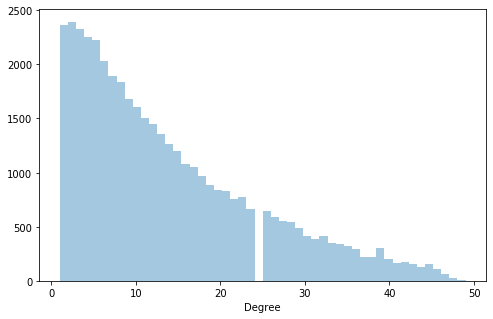

In [31]:
"""Plot the distribution with empty patients and very dense patients removed"""
plt.figure(figsize=(8,5))
ax = sns.distplot(np.count_nonzero(A_cleaned.toarray(), axis=0), kde=False)
ax.set(xlabel="Degree")
plt.savefig("./figures/mknn_featdist_K{}_emptyandoutliersremoved.png".format(k_neighbors))

In [18]:
"""
Save all indexing information for final analysis
"""
#PATIENT_ICD_SUBJECT_IDS maps the "matrix row index" to "patient id"
##We want to keep track of which patients are remaining and which were removed
remaining_subject_ids = pd.read_csv("../../data/PATIENT_ICD_SUBJECT_IDS.csv")
remaining_subject_ids

,SUBJECT_ID
0,109
1,112
2,113
3,114
4,115
...,...
46515,97164
46516,97484
46517,97488
46518,97492


In [ ]:
"""ONLY RUN IF first pass, OTHERWISE skip to next block to load pre-computed indexing file"""
remaining_subject_ids_cleaned = remaining_subject_ids.iloc[rows_with_vals].iloc[degree_threshold_idx]
remaining_subject_ids_cleaned["ORIGINAL_INDEX"] = remaining_subject_ids_cleaned.index
remaining_subject_ids_cleaned.to_csv("./data/REMAINING_SUBJECT_IDS.csv", index=None)

In [16]:
"""
SUBJECT_ID = Patient ID
ORIGINAL_INDEX = Corresponding row index in original, un-processed 46520x46520 adjacency matrix

Important because we can now map indices between the processed adjacency matrix to the original adjacency matrix
"""
remaining_subject_ids = pd.read_csv("./data/REMAINING_SUBJECT_IDS.csv")
remaining_subject_ids

,SUBJECT_ID,ORIGINAL_INDEX
0,109,0
1,112,1
2,113,2
3,114,3
4,115,4
...,...,...
42512,97164,46515
42513,97484,46516
42514,97488,46517
42515,97492,46518


## A rescaling

In [33]:
"""
We rescale and increase values in A to prevent numerical errors later in the pipeline. 

Before, the values in A are small between 0-1. After, they are larger between 1-7.38
"""
A = A_cleaned
print(np.min(A), np.max(A))
print(A.data)
print(A.shape)

0.0 1.0
[0.06656105 0.05220621 0.04366442 ... 0.06948346 0.05569175 0.06488823]
(42517, 42517)


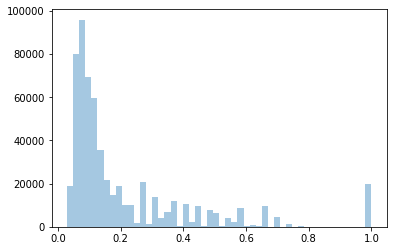

In [35]:
nonzero_idx_A = np.nonzero(A.toarray())

"""Distribution of unscaled data"""
sns.distplot(A[nonzero_idx_A], kde=False)

In [36]:
"""
Rescaling done exponentially has the benefit of accentuating similarity differences in the similarity matrix.
"""
rescaled_data = np.exp(2*A[nonzero_idx_A])

[[1.14238949 1.11005817 1.09125547 ... 1.14908608 1.11782351 1.13857383]]
1.0587944922327113 7.38905609893065


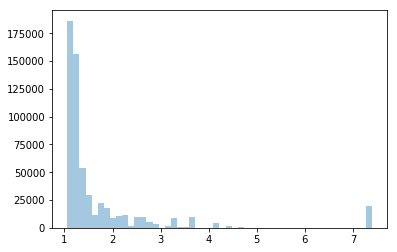

In [43]:
sns.distplot(rescaled_data, kde=False)
print(rescaled_data)
print(np.min(rescaled_data), np.max(rescaled_data))

In [37]:
#Save rescaled data
A_rescaled = A.copy().toarray()
A_rescaled[nonzero_idx_A] = rescaled_data
A_rescaled = csr_matrix(A_rescaled)
print(A_rescaled.min(), A_rescaled.max())

0.0 7.38905609893065


In [45]:
pickle.dump(csr_matrix(A_rescaled), open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

In [38]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape)
print(A.min(), A.max())

(42517, 42517)
0.0 7.38905609893065


# D

In [47]:
"""
D matrix computed by summing rows of A according to Ng et. al.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
"""
D = np.zeros((A.shape[0], A.shape[0]))
for i in tqdm(range(A.shape[0])):
    D[i, i] = np.sum(A[i])
    
pickle.dump(csr_matrix(D), open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

100%|██████████| 42517/42517 [00:09<00:00, 4278.44it/s]


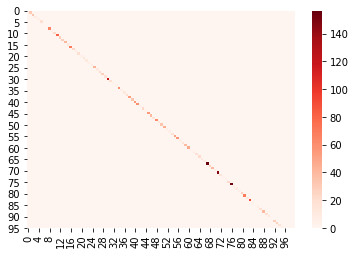

In [39]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
sns.heatmap(D[:100, :100].toarray(), cmap="Reds")

# D_mc (poor variable name for degree-corrected D)

In [41]:
"""
Degree-corrected acts as regularization and theoretically reduces the outlier effect of highly-connected patients 
"""
k_neighbors = 50

In [44]:
diag_idx = np.diag_indices(D.shape[0])
D_mean = np.mean(D[diag_idx])

D_mc = D.copy()
D_mc[diag_idx] = D[diag_idx] + D_mean
print(np.mean(D_mc[diag_idx]), np.mean(D[diag_idx]))

47.203751839879196 23.6018759199396


In [51]:
pickle.dump(csr_matrix(D_mc), open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

# D_inv_sqrt

In [42]:
"""
Compute D^(-1/2) according to Ng et. al.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
"""

k_neighbors = 50

In [45]:
D = pickle.load(open("./data/D_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc = pickle.load(open("./data/D_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
print(D.shape, D_mc.shape)
print(np.mean(D[diag_idx]), np.mean(D_mc[diag_idx]))
print(np.mean(D), np.mean(D_mc))

(42517, 42517) (42517, 42517)
23.6018759199396 47.203751839879196
0.000555116210455573 0.0011102324209111463


In [54]:
def get_inv_sqrt(d):
    #Only divide by nonzero values to prevent nan errors. 
    nonzero_idx = np.nonzero(d)
    d_diag_sqrt_inv = 1.0/np.sqrt(d[nonzero_idx])
    d_inv_sqrt = d.copy()
    d_inv_sqrt[nonzero_idx] = d_diag_sqrt_inv
    return d_inv_sqrt

D_inv_sqrt = get_inv_sqrt(D)
D_mc_inv_sqrt = get_inv_sqrt(D_mc)

In [55]:
pickle.dump(D_inv_sqrt, open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(D_mc_inv_sqrt, open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "wb"))

# Compute normalized L

In [56]:
"""
L and L_mc are both calculated according to Ng et. al. with their respective matrices.
https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf

L_mc = degree corrected L
"""
k_neighbors = 50

In [57]:
A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
D_inv_sqrt = pickle.load(open("./data/D_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
D_mc_inv_sqrt = pickle.load(open("./data/D_mc_mknn_inv_sqrt_K{}_CSR.p".format(k_neighbors), "rb"))
print(A.shape, D.shape, D_mc.shape)

L = D_inv_sqrt.dot(A.dot(D_inv_sqrt))
L_mc = D_mc_inv_sqrt.dot(A.dot(D_mc_inv_sqrt))

pickle.dump(csr_matrix(L), open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "wb"))
pickle.dump(csr_matrix(L_mc), open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "wb"))

(42517, 42517) (42517, 42517) (42517, 42517)


In [58]:
"""The reduced range of L_mc is expected (Increasing values of D_mc => Decreasing inverse of D_mc)"""
print(L.shape, L_mc.shape)
print(np.min(L), np.max(L))
print(np.min(L_mc), np.max(L_mc))

(42517, 42517) (42517, 42517)
0.0 1.0000000000000002
0.0 0.23842639177264768



# Eigen Decomposition

In [14]:
L = pickle.load(open("./data/L_mknn_K{}_CSR.p".format(k_neighbors), "rb"))
L_mc = pickle.load(open("./data/L_mc_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

evecs=2000
L_evecs, L_evals, _ = randomized_svd(L, n_components=evecs)
L_mc_evecs, L_mc_evals, _ = randomized_svd(L_mc, n_components=evecs)
# pickle.dump(L_evecs, open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'wb'))
# pickle.dump(L_mc_evecs, open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "wb"))
# pickle.dump(L_evals, open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))
# pickle.dump(L_mc_evals, open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))

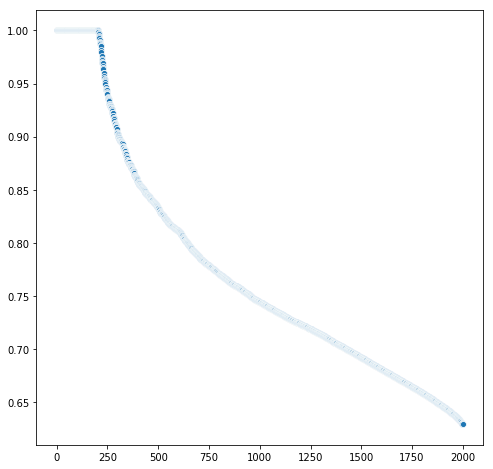

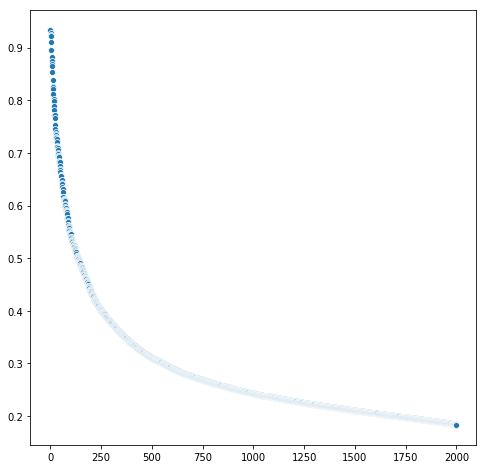

In [15]:
#print(np.flip(L_evals_svd))
plt.figure(figsize=(8,8))
ax = sns.scatterplot(range(L_evals.shape[0]), L_evals)
plt.savefig("./figures/L_EVALS{}.png".format(evecs))

#print(np.flip(L_mc_evals_svd))
plt.figure(figsize=(8,8))
ax = sns.scatterplot(range(L_mc_evals.shape[0]), L_mc_evals)
plt.savefig("./figures/L_mc_EVALS{}.png".format(evecs))

In [16]:
pickle.dump(L_evecs, open("./data/L_evecs{}_K{}.p".format(evecs, k_neighbors), 'wb'))
pickle.dump(L_mc_evecs, open("./data/L_mc_evecs{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_evals, open("./data/L_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))
pickle.dump(L_mc_evals, open("./data/L_mc_evals{}_K{}.p".format(evecs, k_neighbors), "wb"))

In [18]:
L_evecs_top = L_evecs[:, 250:350]
L_mc_evecs_top = L_mc_evecs[:, :100]
pickle.dump(L_evecs_top, open("./data/TOP_L_evecs{}_250_350_K{}.p".format(evecs, k_neighbors), 'wb'))
pickle.dump(L_mc_evecs_top, open("./data/TOP_L_mc_evecs{}_0_100_K{}.p".format(evecs, k_neighbors), "wb"))

In [61]:
"""
evecs_to_plot=20
L_k_evecs = L_evecs[:, -evecs_to_plot:]
L_mc_k_evecs = L_mc_evecs[:, -evecs_to_plot:]

evec_cols = ["Evec_{}".format(i) for i in range(evecs_to_plot)]

L_evec_df = pd.DataFrame(L_k_evecs, columns=evec_cols)
L_mc_evec_df = pd.DataFrame(L_mc_k_evecs, columns=evec_cols)
print(L_evec_df.describe())
print(L_mc_evec_df.describe())
"""

             Evec_0        Evec_1        Evec_2        Evec_3        Evec_4  \
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000   
mean       0.000164      0.000051      0.000480     -0.000257     -0.000085   
std        0.004847      0.004850      0.004826      0.004843      0.004849   
min       -0.134232     -0.190371     -0.164643     -0.162099     -0.182411   
25%       -0.000254     -0.000187      0.000147     -0.000459     -0.000430   
50%        0.000021      0.000119      0.000431      0.000100     -0.000159   
75%        0.000322      0.000428      0.000884      0.000528      0.000059   
max        0.177969      0.215234      0.219077      0.193335      0.186981   

             Evec_5        Evec_6        Evec_7        Evec_8        Evec_9  \
count  42517.000000  42517.000000  42517.000000  42517.000000  42517.000000   
mean      -0.000119     -0.000113     -0.000028     -0.000107      0.000281   
std        0.004848      0.004848      0.004850    

# K-Means clustering